# Genrating ASL lexicons by converting Videos into its coresponding Pose file

Need Dataset : https://www.kaggle.com/datasets/risangbaskoro/wlasl-processed

## Installing

In [ ]:
!pip install pose_format mediapipe tqdm jupyter ipywidgets --upgrade

## Importing

In [ ]:
import sys
error_log_file = "error_log.txt"
sys.stderr = open(error_log_file, "w")
# sys.stderr = sys.__stderr__

import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import json

from pose_format import Pose
from pose_format.pose_visualizer import PoseVisualizer
from pose_format.utils.generic import reduce_holistic
from pose_format.utils.holistic import load_holistic

import cv2
from tqdm.notebook import tqdm
from IPython.display import Image

## Constants

In [ ]:
wlasl_directory = "wlasl-processed"
pose_directory = "poses"
gif_file = "demo.gif"

if not os.path.exists(pose_directory):
    os.mkdir(pose_directory)

## Converting

In [ ]:
def load_video_frames(cap: cv2.VideoCapture):
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        yield cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cap.release()


def pose_video(input_path: str, output_path: str, format: str = 'mediapipe', log: bool = True):
    
    # Load video frames
    if log: print()
    if log: print('Loading video ...')
    cap = cv2.VideoCapture(input_path)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frames = load_video_frames(cap)

    # Perform pose estimation
    if log: print('Estimating pose ...')
    if format == 'mediapipe':
        pose = load_holistic(frames, fps=fps, width=width, height=height,
                             progress=True, additional_holistic_config={'model_complexity': 1})
    else:
        raise NotImplementedError('Pose format not supported')
    
    # Reduce Holistic (Removing 3D body world landmark representation)
    # pose = pose.get_components(["POSE_LANDMARKS", "FACE_LANDMARKS", "LEFT_HAND_LANDMARKS", "RIGHT_HAND_LANDMARKS"])
    # or
    if log: print('Reducing Holistic ...')
    pose = reduce_holistic(pose)
    
    # Write
    if log: print('Saving to disk ...')
    with open(output_path, "wb") as f:
        pose.write(f)


def find_missing_pose_files(video_directory: str, pose_directory: str):
    all_video_files = os.listdir(video_directory)
    all_pose_files = os.listdir(pose_directory)
    
    mp4_files = [f for f in all_video_files if f.endswith(".mp4")]
    print("Total:", len(mp4_files))
    pose_files = {f.removesuffix(".pose") for f in all_pose_files if f.endswith(".pose")}
    print("Done:", len(pose_files))
    
    missing_pose_files = []
    for mp4_file in mp4_files:
        base_name = mp4_file.removesuffix(".mp4")
        
        if base_name not in pose_files:
            missing_pose_files.append(os.path.join(video_directory, mp4_file))
    
    print("Left:", len(missing_pose_files))
    return sorted(missing_pose_files)


def handel_directory(video_directory: str, pose_directory: str, log: bool = True):
    missing_pose_files = find_missing_pose_files(video_directory, pose_directory)

    for mp4_path in tqdm(missing_pose_files):
        pose_file_name = Path(pose_directory) / (Path(mp4_path).stem + ".pose")
        pose_video(mp4_path, pose_file_name, 'mediapipe', log)

In [ ]:
# Single file
# pose_video("demo.mp4", "demo.pose", 'mediapipe')

# Multiple files
# handel_directory(f"{wlasl_directory}/videos","poses", False)

## Visualization

In [ ]:
def visualize(pose_file: str, gif_file: str):
    with open(pose_file, "rb") as f:
        pose = Pose.read(f.read())

    # Scale Down
    # scale = pose.header.dimensions.width / 256
    # pose.header.dimensions.width = int(pose.header.dimensions.width / scale)
    # pose.header.dimensions.height = int(pose.header.dimensions.height / scale)
    # pose.body.data = pose.body.data / scale

    # Scale Up
    # pose.body.data *= 2 # scale pose values
    # pose.header.dimensions.width *= 2 # scale video dimension
    # pose.header.dimensions.height *= 2 # scale video dimension

    vis = PoseVisualizer(pose, thickness=1)
    vis.save_gif(gif_file, vis.draw())
    display(Image(open(gif_file,'rb').read()))

    
with open(f"{wlasl_directory}/WLASL_v0.3.json") as f:
    wlasl = json.load(f)


glosses = {gloss["gloss"]:i for i, gloss in enumerate(wlasl)}
glosses.keys()

done
{'bbox': [354, 41, 1006, 720], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 0, 'signer_id': 115, 'source': 'aslbrick', 'split': 'test', 'url': 'http://aslbricks.org/New/ASL-Videos/done.mp4', 'variation_id': 0, 'video_id': '69300'}
wlasl-processed/videos/69300.mp4

Loading video ...
Estimating pose ...
Reducing Holistic ...
Saving to disk ...
poses/69300.pose
Converting to gif ...



I0000 00:00:1708087080.048444   44073 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1708087080.051483   44284 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.3.2-1pop0~1704238321~22.04~36f1d0e), renderer: Mesa Intel(R) UHD Graphics 630 (CFL GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


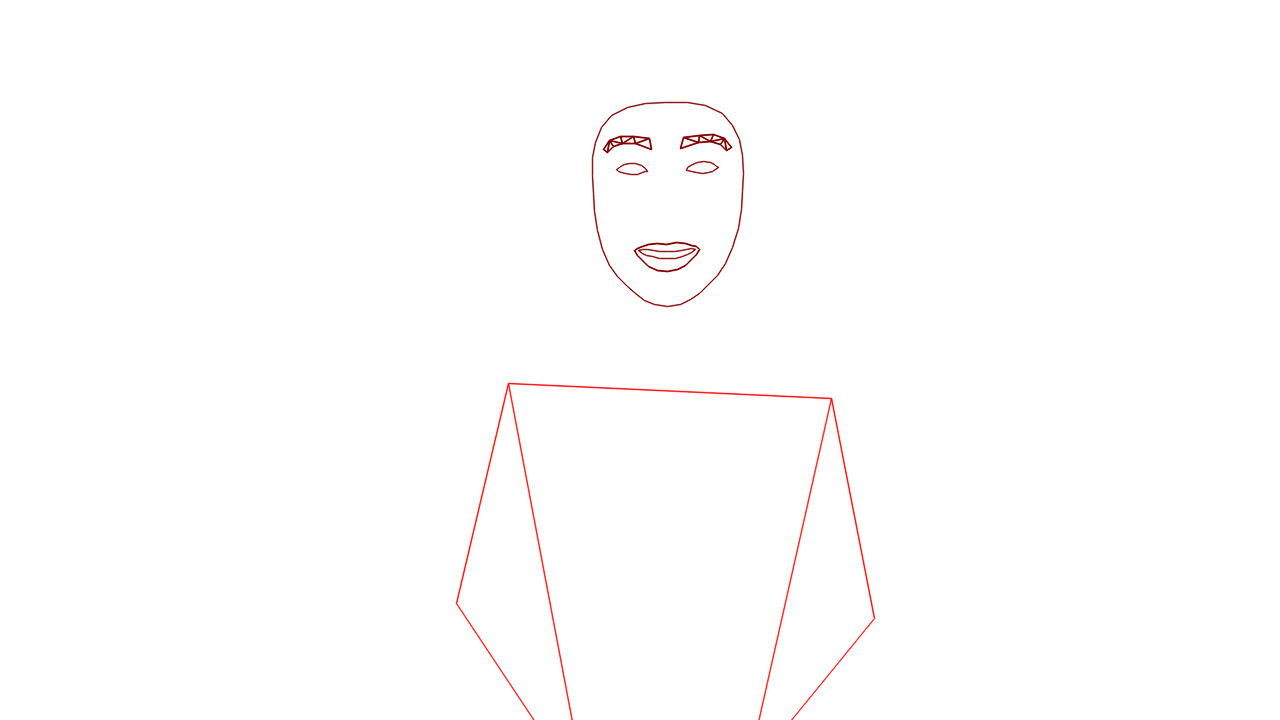

In [5]:
word = input("Enter gloss: ")
print(word)

try:
    idx = glosses[word]
    gloss = wlasl[idx]
except:
    raise RuntimeError("Gloss is not available")


for instance in gloss["instances"]:
    video_id = instance["video_id"]
    pose_path = f'{pose_directory}/{video_id}.pose'

    if not os.path.exists(pose_path):
        video_path = f'{wlasl_directory}/videos/{video_id}.mp4'

        if os.path.exists(video_path):
            print(instance)
            print(video_path)
            pose_video(video_path, pose_path, 'mediapipe')
        else:
            continue
    
    print(pose_path)
    print("Converting to gif ...")
    print()
    visualize(pose_path, gif_file)
    break

else:
    print("No videos found for", str(idx))